<a href="https://colab.research.google.com/github/sg879/IIBProject/blob/main/Test/Test_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Creating Test Data

## Import and Load Packages

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import scipy.io as io
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random
import jax.lax as lax

In [5]:
from jax.config import config
config.update("jax_enable_x64", True)

## Function Definitions

In [6]:
@jit
def squared_exp(i, j, tau, ell, sigma_f):
  return sigma_f**2.0*jnp.exp(-(tau[i]-tau[j])**2/(2*ell**2.0))

In [7]:
@jit
def squared_exp2(i, j, ell, sigma_f):
  return sigma_f**2.0*jnp.exp(-(i-j)**2/(2*ell**2.0))

In [8]:

#def cov_squared_exp(tau, ell, sigma_f):
#  k = jnp.shape(tau)[0]
#  covmat = jnp.empty((k,k)).astype(jnp.float32)
# for i in jnp.arange(k):
#    for j in np.arange(k):
#      covmat = covmat.at[i, j].set(squared_exp(i, j, tau, ell, sigma_f))
#  return covmat

In [9]:
# Vectorised SE function
vec_SE = vmap(vmap(squared_exp2, in_axes=[None,0,None,None]),in_axes=[0,None,None,None])

## Create Input, Filter and Noise

### Generate random number key

In [10]:
key = random.PRNGKey(1)

# Split key to get usable subkeys in case of future editing
key, *subkeys = random.split(key, 4)

### Make random input spike train

In [11]:
# Get subkey
subkeyx = subkeys[-1]

# Set up time indexing
Input_mt = 0.5
tbin_l = 0.005
K = jnp.floor(Input_mt/tbin_l).astype(jnp.int32)
timex = jnp.linspace(0.0, Input_mt, K+1)

inpx = random.bernoulli(subkeyx, 0.2, (K+1,1))

In [12]:
print(K)

100


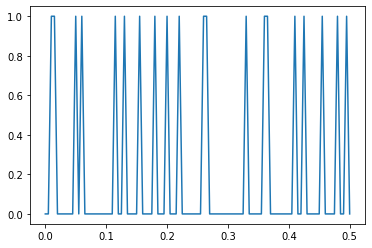

In [13]:
plt.plot(timex, inpx)

### Generate filter shape

In [14]:
# Get subkey
subkeyf = subkeys[-2]

# Set up time indexing
Filter_mt = 0.1
M = jnp.floor(Filter_mt/tbin_l).astype(jnp.int32)
timef = jnp.linspace(0.0, Filter_mt, M+1)

# True mean and covariance
muf_true = jnp.zeros((M+1,1))
covf_true = vec_SE(timef, timef, 0.01 , 1.0)

# Generate filter from true mean and covariance
chol_true = jsc.linalg.cholesky(covf_true)
f_true = muf_true + chol_true@random.normal(subkeyf, (M+1,1))
#f_true = jnp.sin(timef*32.0).reshape((M+1,1))

In [15]:
print(M)

20


In [16]:
print(jnp.shape(f_true))

(21, 1)


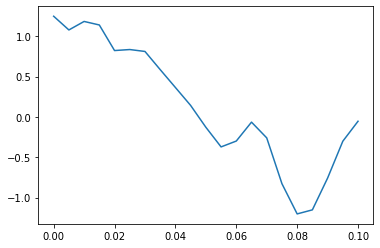

In [17]:
plt.plot(timef, f_true)

### Noise vector

In [18]:
# Get subkey 
subkeyn = subkeys[-3]

# Noise variance
sigma_n = 0.05

# Noise vector
noise_vec = sigma_n*random.normal(subkeyn, (M+K+1, 1))

## Generate Output

In [27]:
# Pad input and filter
xp_true = jnp.vstack((inpx, jnp.zeros((M,1))))
fp_true = jnp.vstack((f_true, jnp.zeros((K,1))))

# Compute the FFTs
X_true = jnp.fft.fft(xp_true)
F_true = jnp.fft.fft(fp_true)

# Elementwise multiplication
fftmul = jnp.multiply(X_true, F_true)

# Make output and time
y_truetry = jnp.real(jnp.fft.ifft(fftmul) + noise_vec)
y_true = jnp.convolve(inpx.flatten(), f_true.flatten()) + noise_vec.flatten()
timey = np.linspace(0, Input_mt+Filter_mt, K+M+1)

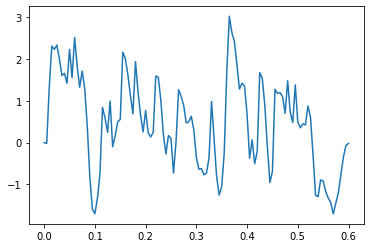

In [28]:
plt.plot(timey, y_true)

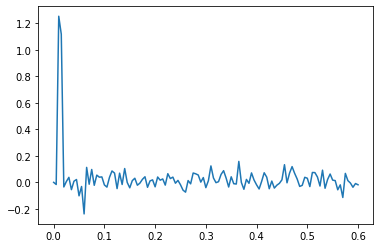

In [29]:
plt.plot(timey, y_truetry)

## Saving the data

In [22]:
print(y_true.flatten())

[-1.35438527e-03 -1.74539495e-02  1.31731885e+00  2.30482373e+00
  2.22790719e+00  2.33038347e+00  2.00101749e+00  1.60334668e+00
  1.65581472e+00  1.41928676e+00  2.22630320e+00  1.55422018e+00
  2.50806317e+00  1.83146137e+00  1.32126285e+00  1.70874824e+00
  1.28750568e+00  3.87678384e-01 -8.17087859e-01 -1.58768191e+00
 -1.69618331e+00 -1.32754489e+00 -7.46646392e-01  8.43252545e-01
  5.88429205e-01  2.42847311e-01  9.94699411e-01 -9.64024902e-02
  1.61131448e-01  4.96371413e-01  5.55267600e-01  2.16036199e+00
  2.01017688e+00  1.62041458e+00  1.12665227e+00  6.88289985e-01
  1.93354091e+00  1.22082015e+00  6.53325642e-01  2.55132570e-01
  7.67111654e-01  2.38612404e-01  1.34713070e-01  2.45953694e-01
  1.59200469e+00  1.56032825e+00  1.01389683e+00  1.90184698e-01
 -2.71759278e-01  1.68299249e-01  1.03134895e-01 -7.27649646e-01
  3.60644318e-02  1.26527843e+00  1.10434683e+00  8.92389549e-01
  4.71136653e-01  4.95652668e-01  6.29979121e-01  3.03743778e-01
 -3.46587901e-01 -6.34740

In [23]:
np.save('drive/MyDrive/Project/Test/Testy.npy', y_true)
np.save('drive/MyDrive/Project/Test/Testx.npy', inpx)
np.save('drive/MyDrive/Project/Test/Truef.npy', f_true)
np.save('drive/MyDrive/Project/Test/Inputwin.npy', Input_mt)
np.save('drive/MyDrive/Project/Test/Outputwin.npy', timey[-1])
np.save('drive/MyDrive/Project/Test/Noise.npy', sigma_n)

In [24]:
datdic = mdic = {"Xdat": inpx, "Fdat": f_true}

In [25]:
io.savemat('drive/MyDrive/Project/Test/TestDataMat.mat', datdic)

In [26]:
print(timef[-1])

0.1
